# Module 8 #

Convert a 3D image into a spherical harmonic representation using CellOrganizer SPHARM-RPDM functionality

Then create both a mesh reconstruction and an image reconstruction from the SPHARM-RPDM representation 


In [1]:
#import packages
from aicsimageio import AICSImage
import numpy as np
from pathlib import Path
from cellorganizer.tools import image2SPHARMparameterization, SPHARMparameterization2image, SPHARMparameterization2mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

# Image 2 SPHARM PARAMS #

Take a 3D image and convert into spherical parameters. The output will be a structure containing the parameters and other metadata information of the image.

In [2]:
#set options
# options = {}
# options['NMfirsttry_maxiter'] = 300
# options['NMretry_maxiter'] = 100
# options['NMretry_maxiterbig'] = 300

# # decreasing these numbers decreases compute time but potential reduces model quality
# options['NMcost_tol'] = 1e-7
# options['NMlargr_tol'] = 1e-7

# # degree of spherical harmonic descriptor
# options['maxDeg'] = 31
# # if the error in the parameterization for a given cell is higher than this, discard that cell
# # (note that there is a separate option hd_threshold that controls which cells are in reports)
# options['hd_thresh'] = 10

In [2]:
#read in selected image
directory = '/home/murphylab/cellorganizer/local/images/HeLa/3D/processed/'
cellImagesDirectoryPath = Path(directory + 'LAM_cell1_ch1_t1.tif')
img = AICSImage(cellImagesDirectoryPath)

Preprocess image to get it in the proper dimensions and downsample (for faster execution).

In [4]:
data = img.data
data = np.squeeze(data) #get it down to a 3D image
data = np.transpose(data, (1, 2, 0)) #transpose to xyz
print(data.shape)
#downsample
data = data[::8,::8,::2]
#make sure data is shaped correctly
print(data.shape)

(1024, 1024, 18)
(128, 128, 9)


In [5]:
params = image2SPHARMparameterization(data) #return back descriptors as dict
#params = image2SPHARMparameterization(data, options) #if user specific options are set

CellOrganizer v2.10 (MATLAB RO2019a)


In [6]:
params

{'deg': 31,
 'fvec': array([[ 2.37426862e+02+1.51187166e-20j,  2.82661825e+02-9.60038506e-19j,
          1.36037158e+01-6.23647061e-20j],
        [ 4.53240957e+01+2.81583090e+00j, -2.12219958e+01-6.44935543e+00j,
          8.24771118e-01-8.23394535e+00j],
        [ 2.01318678e+01+1.33047737e-18j,  6.72422602e+01+2.35857351e-18j,
         -1.10349871e+00+5.14048074e-19j],
        ...,
        [ 1.93703969e-03-1.71598332e-02j, -1.07885147e-03+1.13916427e-02j,
         -4.69425689e-04+6.73839131e-03j],
        [ 2.42286050e-02-1.07693263e-02j, -1.72980528e-02+1.06872011e-03j,
          6.61298299e-04+1.48682574e-02j],
        [ 3.35741565e-02-2.94982145e-02j, -1.37115127e-02+1.30289842e-02j,
         -6.53269660e-03-2.23560688e-02j]]),
 'vertices': array([[ 60,  37,   0],
        [ 61,  37,   0],
        [ 62,  37,   0],
        ...,
        [ 70, 102,   9],
        [ 71, 102,   9],
        [ 72, 102,   9]], dtype=uint8),
 'faces': array([[3923, 3892, 3067, 3080],
        [3928, 3895, 307

# SPHARM PARAMS 2 MESH #

In [7]:
#set options
# options = {}

#options['meshtype.type'] = 'even'
#options['meshtype.nPhi'] = 64
#options['meshtype.nTheta'] = 32


# options['meshtype.type'] = 'triangular';
# options['meshtype.nVertices'] = 4002;

# options['figtitle'] = []
# options['plot'] = 0 #show mesh figure
# options['dpi'] = 150

In [8]:
mesh_mat = SPHARMparameterization2mesh(params)
# mesh_mat = SPHARMparameterization2mesh(params, options) #if user specific options are set

CellOrganizer v2.10 (MATLAB RO2019a)


In [9]:
mesh_mat

{'Zvert': array([[ 76.66073238, 105.51369009,   1.98588317],
        [ 75.54785447, 105.70447051,   1.7815051 ],
        [ 76.87800889, 105.60208468,   2.62092803],
        ...,
        [ 57.06222556,  32.3282838 ,   4.43354431],
        [ 56.98420298,  30.80466201,   4.53471301],
        [ 56.56509054,  30.30116004,   4.37329848]]),
 'fs': array([[1971, 2115, 2026],
        [1759, 1903, 1814],
        [1759, 1848, 1903],
        ...,
        [3692, 3747, 3713],
        [3692, 3726, 3747],
        [3726, 3781, 3747]], dtype=uint16)}

# 3D visualization from the mesh

4002
8000


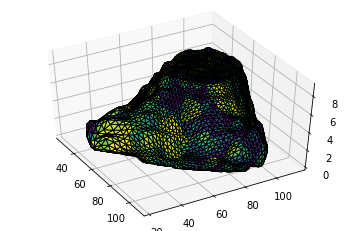

In [10]:
# vertices
v = mesh_mat['Zvert']
print(len(v))
# faces
f = mesh_mat['fs']-1
print(len(f))

# assign a "color number" equal to the index of the face
C = np.array(list(range(len(mesh_mat['fs']))))
## an alternative is to assign each face a "color number" matching its average z coordinate
#C=np.empty(len(f))
#for itup in range(len(f)):
#    C[itup]=np.mean(v[f[itup]], axis=0)[2]
# normalize the color numbers to range 0-1
norm = plt.Normalize(C.min(), C.max())
# assign a color to each face
colors = plt.cm.viridis(norm(C))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)
vmins = np.amin(v, axis=0)
vmaxs = np.amax(v, axis=0)
ax.set_xlim(vmins[0], vmaxs[0])
ax.set_ylim(vmins[1], vmaxs[1])
ax.set_zlim(vmins[2], vmaxs[2])

elevation = 45
azimuth = 330
ax.view_init(elevation, azimuth)
plt.show()

# SPHARM PARAMS 2 IMAGE #

In [11]:
# options['cropping'] = 'tight'
# options['oversampling_scale'] = 1
# options['debug'] = True
# print(options)
img_mat = SPHARMparameterization2image(params)
# img_mat = SPHARMparameterization2image(params, options) #if user specific options are set
print(img_mat)

CellOrganizer v2.10 (MATLAB RO2019a)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


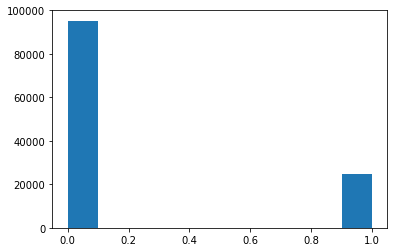

In [12]:
#Make a histogram of pixel values of synthesized image as a sanity check.
fig=plt.figure()
plt.hist(img_mat.ravel())
plt.show()

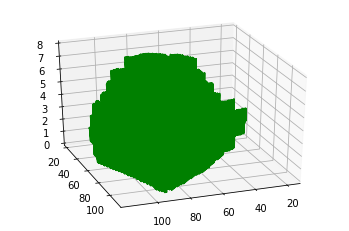

In [13]:
#make a projection of the 3D output image
abovezeroind = np.argwhere(img_mat)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.view_init(elev=30, azim=70)  
ax.plot3D(abovezeroind[:,0],abovezeroind[:,1],abovezeroind[:,2],'green')
plt.show()

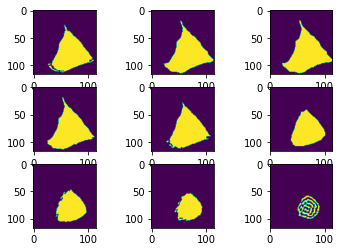

In [14]:
#Now plot the individual xy slices of the 3D image
fig = plt.figure()
#islice = round(img_mat.shape[2]/2)
import math
panels = math.ceil(math.sqrt(img_mat.shape[2]))
for i in range(img_mat.shape[2]):
    plt.subplot(panels,panels,i+1)
    plt.imshow(img_mat[:,:,i])
plt.show()